# 0 - IMPORTS

In [74]:
import random

import pandas                 as pd
import numpy                  as np
import datetime               as dt
import seaborn                as sns
import matplotlib.pyplot      as plt

from xgboost                  import XGBClassifier
from sklearn.ensemble         import RandomForestClassifier
from dython.nominal           import associations

from boruta                   import BorutaPy

from sklearn                  import preprocessing
from sklearn                  import model_selection        as ms
from sklearn                  import metrics                as mts
from sklearn                  import ensemble               as en
from scikitplot               import metrics                as mt

from keras                    import models                 as ml
from keras                    import layers                 as l

## 0.1 - Helper functions

In [2]:
# Supressão da notação científica
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.2 - Loading data

In [3]:
# Loading dataset
df = pd.read_csv('dataset/cardio_train.csv', low_memory=False, sep=';')

# 1 - DESCRIÇÃO DOS DADOS

In [4]:
df1 = df.copy()

## 1.1 - Data dimensions

In [5]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 70000
Número de colunas: 13


## 1.2 - Data types

In [6]:
df1.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

In [7]:
to_object_dict = {'gender': 'object', 
                  'cholesterol': 'object', 
                  'gluc': 'object', 
                  'smoke': 'object', 
                  'alco': 'object', 
                  'active': 'object'}
df1 = df1.astype(to_object_dict)

In [8]:
df1.dtypes

id               int64
age              int64
gender          object
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol     object
gluc            object
smoke           object
alco            object
active          object
cardio           int64
dtype: object

## 1.3 - Check NA

In [9]:
df1.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

## 1.4 - Check dados desbalanceados

In [10]:
df1['cardio'].value_counts()/df1.shape[0]

0   0.500
1   0.500
Name: cardio, dtype: float64

**Dados balanceados**

## 1.5 - Estatística descritiva

### 1.5.1 - Numerical attributes

In [11]:
num_attributes = df1.select_dtypes(include=['float64', 'int64'])

In [12]:
# Tendência central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenação
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributos', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributos,min,max,range,mean,median,std,skew,kurtosis
0,id,0.000,99999.000,99999.000,49972.420,50001.500,28851.096,-0.001,-1.198
1,age,10798.000,23713.000,12915.000,19468.866,19703.000,2467.234,-0.307,-0.823
2,height,55.000,250.000,195.000,164.359,165.000,8.210,-0.642,7.944
3,weight,10.000,200.000,190.000,74.206,72.000,14.396,1.012,2.587
4,ap_hi,-150.000,16020.000,16170.000,128.817,120.000,154.010,85.296,7580.075
5,ap_lo,-70.000,11000.000,11070.000,96.630,80.000,188.471,32.114,1425.915
6,cardio,0.000,1.000,1.000,0.500,0.000,0.500,0.001,-2.000


### 1.5.2 - Categorical attributes

In [13]:
cat_attributes = df1.select_dtypes(exclude=['float64', 'int64'])

In [14]:
cat_attributes.describe()

,gender,cholesterol,gluc,smoke,alco,active
count,70000,70000,70000,70000,70000,70000
unique,2,3,3,2,2,2
top,1,1,1,0,0,1
freq,45530,52385,59479,63831,66236,56261


# 2 - FEATURE ENGINEERING

In [15]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

## 2.2 - Criação das hipóteses

**1)** Pessoas mais velhas devem ter mais predisposição a ter doenças cardíacas.

**2)** Não há distinção entre a taxa de doenças cardíacas para homens e mulheres.

**3)** Pessoas mais altas têm maior possibilidade de desenvolver doenças cardíacas.

**4)** Quanto maior o peso do paciente, maior a probabilidade de desenvolver doenças cardíacas.

**5)** Pessoas com valor de IMC elevado têm maior possibilidade de possuir doença cardíaca.

**6)** Quanto mais alto o colesterol, maior a probabilidade de possuir doenças cardíacas.

**7)** Pessoas com valores de glicose altos tendem a ter maior predisposição em desenvolver doenças cardíacas.

**8)** Fumantes são mais propensos a desenvolver doenças cardíacas.

**9)** Pessoas que bebem álcool ativamente são mais propensos a desenvolver doenças cardíacas.

**10)** Pessoas não ativas são mais propensas a possuir doenças cardíacas.

**11)** Pessoas com pressão sistólica alta têm maior predisposição a desenvolver doenças cardíacas.

**12)** Pessoas com pressão diastólica alta têm maior predisposição a desenvolver doenças cardíacas.

**13)** Pessoas com a relação pressões sistólica/diastólica alta têm maior predisposição a desenvolver doenças cardíacas.

## 2.3 - Feature engineering

In [16]:
# age - dias para anos
df2['age'] = df2['age']/365.25
df2['age'] = df2['age'].astype(int)

# Criação da feature IMC
df2['imc'] = df2['weight']/((df2['height']/100)**2)
df2['imc'] = df2['imc'].apply(lambda x: round(x,1))

# Criação da feature ap_hi_lo
df2['ap_hi_lo'] = df2['ap_hi']/df2['ap_lo']
df2['ap_hi_lo'] = df2['ap_hi_lo'].apply(lambda x: round(x,1))

# 3 - FILTRAGEM DE DADOS

In [17]:
df3 = df2.copy()

## 3.1 - Filtragem de linhas

In [18]:
# Apenas pressão sistólica maior que diastólica
df3 = df3[df3['ap_hi'] > df3['ap_lo']]

In [19]:
df3.shape

(68764, 15)

## 3.2 - Seleção de colunas

In [20]:
df3 = df2.drop('id', axis=1)

# 4 - ANÁLISE EXPLORATÓRIA DE DADOS

In [21]:
df4 = df3.copy()

## 4.1 - Análise univariada

### 4.1.1 - Variável resposta

In [22]:
df4['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [23]:
df1['cardio'].value_counts()/df1.shape[0]

0   0.500
1   0.500
Name: cardio, dtype: float64

**Observação:** Constata-se que o dataset possui um ótimo balanceamento dos dados.

### 4.1.2 - Variáveis numéricas

In [24]:
num_attributes = df4.select_dtypes(include=['int64', 'float64']).drop(['cardio', 'ap_hi_lo'], axis=1)

/tmp/ipykernel_4440/124328891.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax=ax, bins=50);


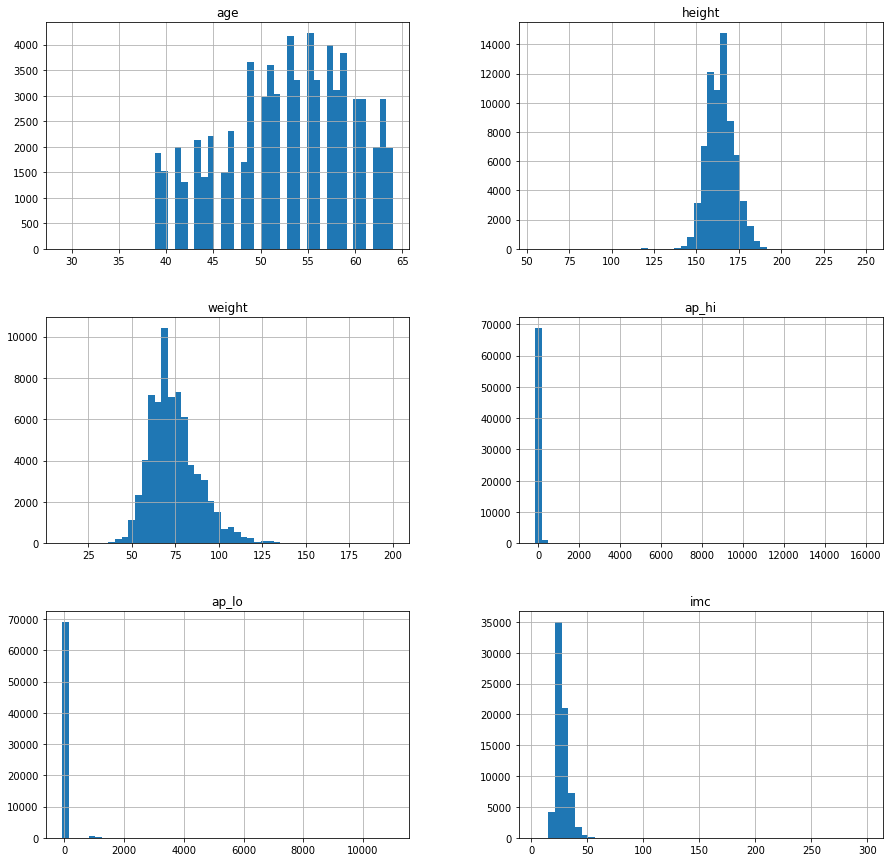

In [25]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50);

### 4.1.3 - Variáveis categóricas

In [26]:
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64'])

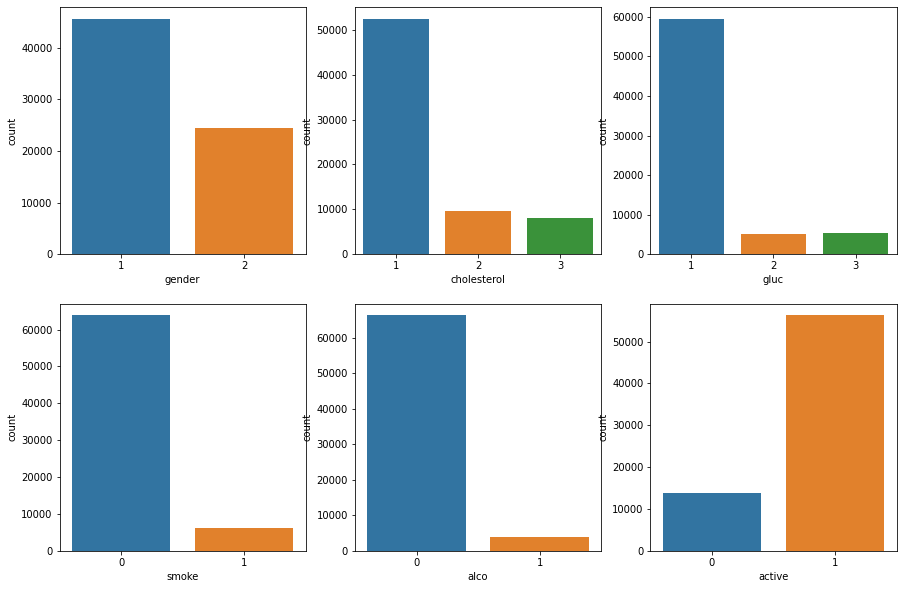

In [27]:
plt.figure(figsize=(15,10))
# gender
plt.subplot(2, 3, 1)
sns.countplot(x='gender', data=cat_attributes)

# cholesterol
plt.subplot(2, 3, 2)
sns.countplot(x='cholesterol', data=cat_attributes)

# gluc
plt.subplot(2, 3, 3)
sns.countplot(x='gluc', data=cat_attributes)

# smoke
plt.subplot(2, 3, 4)
sns.countplot(x='smoke', data=cat_attributes)

# alco
plt.subplot(2, 3, 5)
sns.countplot(x='alco', data=cat_attributes)

# active
plt.subplot(2, 3, 6)
sns.countplot(x='active', data=cat_attributes);

## 4.2 - Análise bivariada

### 1) Pessoas mais velhas devem ter mais predisposição a ter doenças cardíacas.

**VERDADEIRO** Pessoas mais velhas são mais propensas a ter doenças cardíacas.

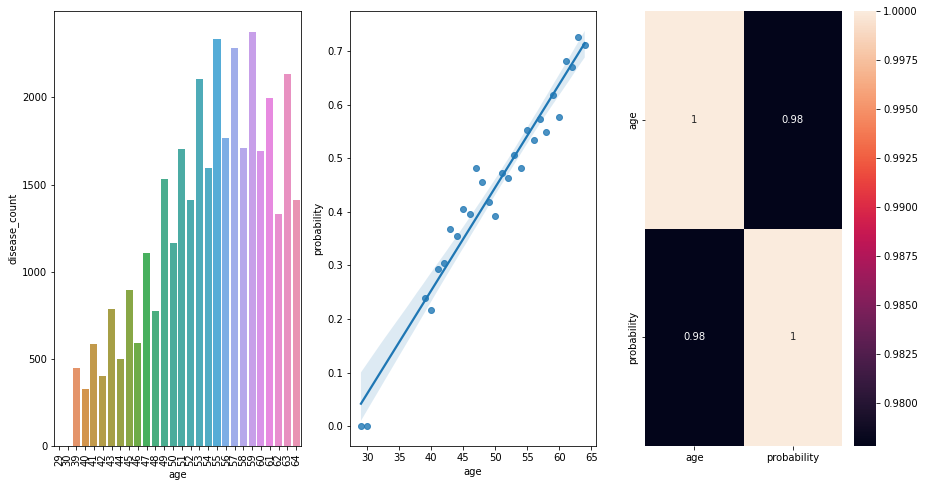

In [28]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
aux1 = df4[['age', 'cardio']].groupby('age').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='age', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = df4[['age', 'cardio']].copy()
aux2 = aux2.groupby('age').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='age')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='age', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['age', 'probability']].corr(method='pearson'), annot=True);

### 2) Não há distinção entre a taxa de doenças cardíacas para homens e mulheres.

**VERDADEIRO** Não há distinção entre a taxa de doenças cardíacas entre homens e mulheres.

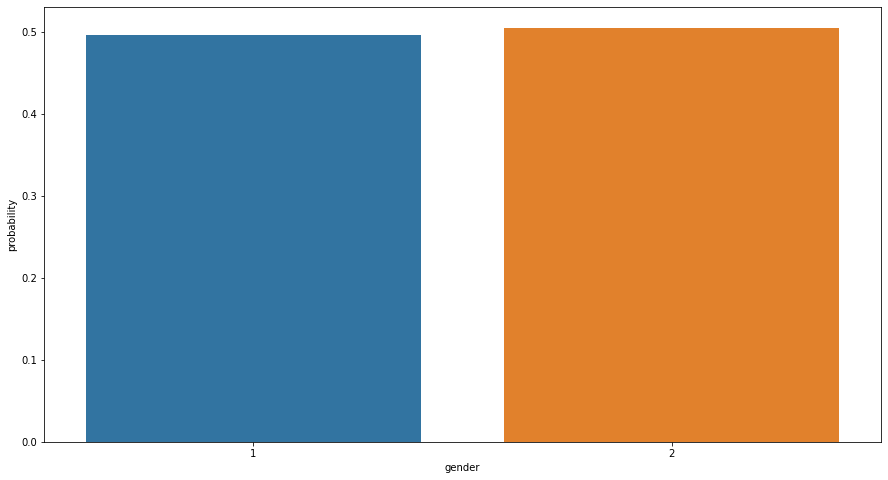

In [29]:
plt.figure(figsize=(15,8))

aux1 = df4['gender'].value_counts().reset_index()
aux1 = aux1.rename(columns={'index': 'gender', 'gender': 'count'})

aux2 = pd.DataFrame([
                        [1, df4[(df4['gender']==1) & (df4['cardio']==1)].shape[0]],
                        [2, df4[(df4['gender']==2) & (df4['cardio']==1)].shape[0]]
                    ],
                    columns=['gender', 'disease_count']
)

aux1 = pd.merge(aux1, aux2, how='left', on='gender')
aux1['probability'] = aux1['disease_count']/aux1['count']
sns.barplot(x='gender', y='probability', data=aux1);

### 3) Pessoas mais altas têm maior possibilidade de desenvolver doenças cardíacas.

**FALSO** Não há relação entre as duas variáveis quando avaliadas juntas sem o envolvimento de outras variáveis.

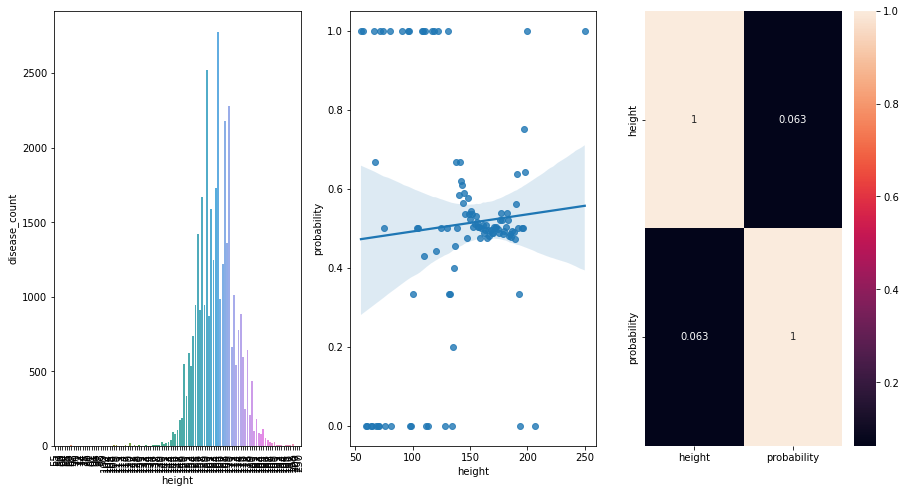

In [30]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
aux1 = df4[['height', 'cardio']].groupby('height').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='height', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = df4[['height', 'cardio']].copy()
aux2 = aux2.groupby('height').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='height')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='height', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['height', 'probability']].corr(method='pearson'), annot=True);

### 4) Quanto maior o peso do paciente, maior a probabilidade de desenvolver doenças cardíacas.

**VERDADEIRO** Apesar de uma relação fraca, quanto maior o peso do paciente, maior a probabilidade de desenvolver doenças cardíacas.

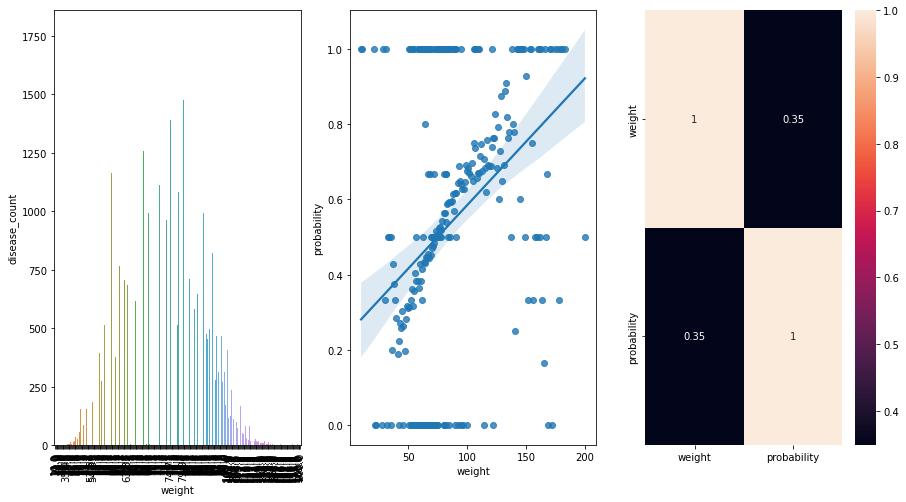

In [31]:
plt.figure(figsize=(15,8))

plt.subplot(1,3,1)
aux1 = df4[['weight', 'cardio']].groupby('weight').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='weight', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = df4[['weight', 'cardio']].copy()
aux2 = aux2.groupby('weight').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='weight')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='weight', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['weight', 'probability']].corr(method='pearson'), annot=True);

### 5) Pessoas com valor de IMC elevado têm maior possibilidade de possuir doença cardíaca.

**VERDADEIRO** Pessoas com valor de IMC elevado têm maior probabilidade de possuir doença cardíaca.

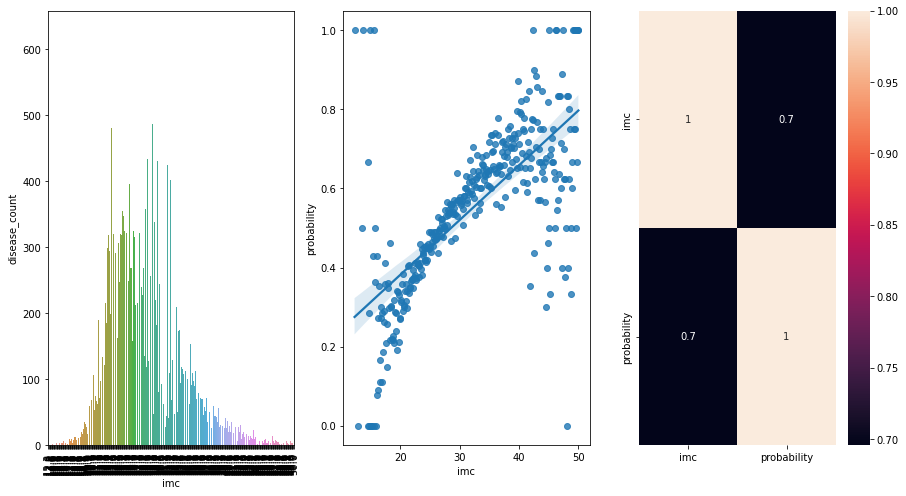

In [32]:
plt.figure(figsize=(15,8))

# Incosistência encontrada nos dados de altura e peso: trabalhando apenas com IMCs entre 12 e 50
aux = df4[(df4['imc']>=12) & (df4['imc']<=50)] 

plt.subplot(1,3,1)
aux1 = aux[['imc', 'cardio']].groupby('imc').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='imc', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = aux[['imc', 'cardio']].copy()
aux2 = aux2.groupby('imc').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='imc')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='imc', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['imc', 'probability']].corr(method='pearson'), annot=True);

### 6) Quanto mais alto o colesterol, maior a probabilidade de possuir doenças cardíacas.

**VERDADEIRO** Quanto mais alto o colesterol, maior a probabilidade de possuir doença cardíaca.

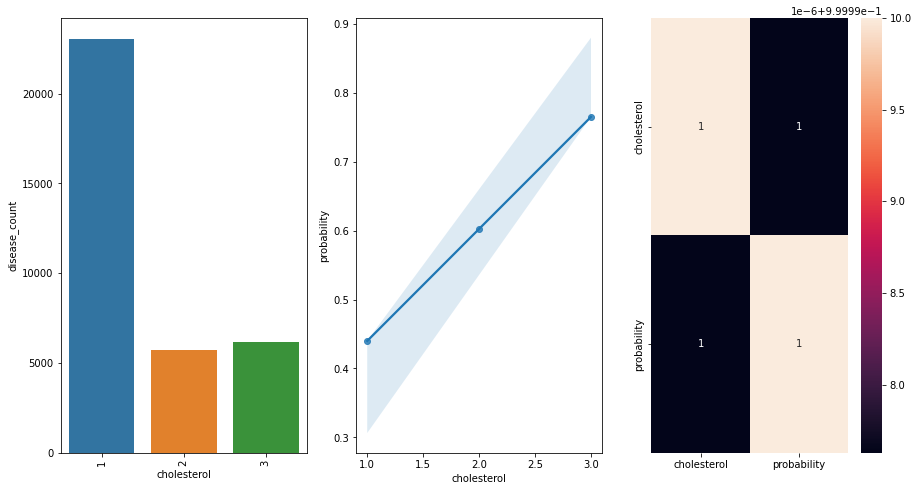

In [33]:
plt.figure(figsize=(15,8)) 

plt.subplot(1,3,1)
aux1 = df4[['cholesterol', 'cardio']].groupby('cholesterol').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='cholesterol', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = df4[['cholesterol', 'cardio']].copy()
aux2 = aux2.groupby('cholesterol').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='cholesterol')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='cholesterol', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['cholesterol', 'probability']].corr(method='pearson'), annot=True);

### 7) Pessoas com valores de glicose altos tendem a ter maior predisposição em desenvolver doenças cardíacas.

**VERDADEIRO** Quanto mais alto o valor de glicose, maior a probabilidade de possuir doença cardíaca.

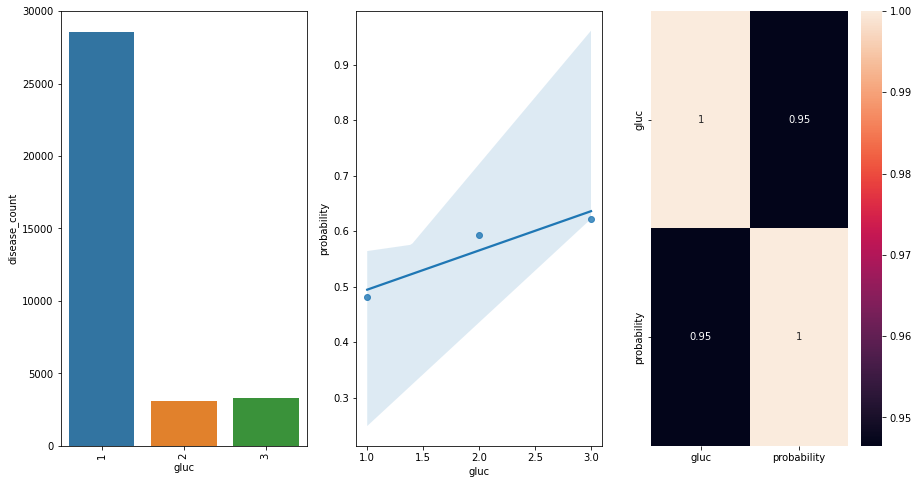

In [34]:
plt.figure(figsize=(15,8)) 

plt.subplot(1,3,1)
aux1 = df4[['gluc', 'cardio']].groupby('gluc').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='gluc', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = df4[['gluc', 'cardio']].copy()
aux2 = aux2.groupby('gluc').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='gluc')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='gluc', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['gluc', 'probability']].corr(method='pearson'), annot=True);

### 8) Fumantes são mais propensos a desenvolver doenças cardíacas.

**FALSO** Não há relação entre as duas variáveis quando avaliadas juntas sem o envolvimento de outras variáveis.

<AxesSubplot:xlabel='smoke', ylabel='probability'>

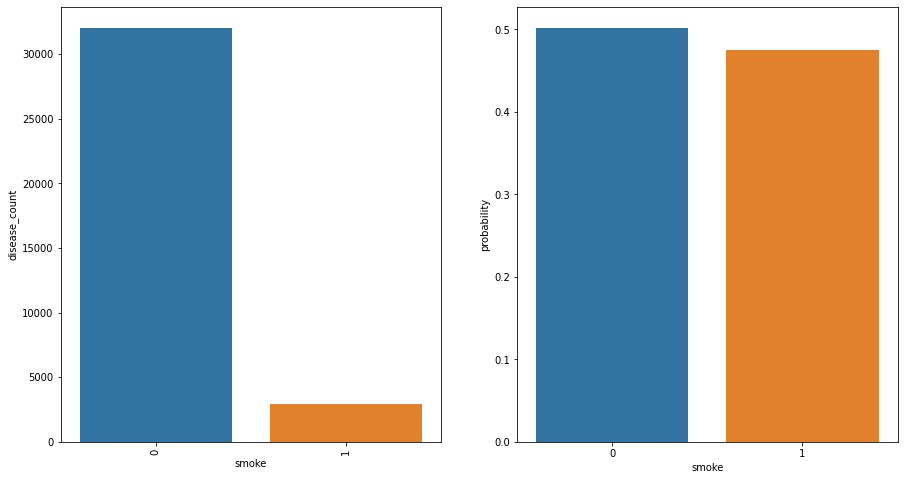

In [35]:
plt.figure(figsize=(15,8)) 

plt.subplot(1,2,1)
aux1 = df4[['smoke', 'cardio']].groupby('smoke').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='smoke', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
aux2 = df4[['smoke', 'cardio']].copy()
aux2 = aux2.groupby('smoke').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='smoke')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.barplot(x='smoke', y='probability', data=aux1)

### 9) Pessoas que bebem álcool ativamente são mais propensos a desenvolver doenças cardíacas.

**FALSO** Não há relação entre as duas variáveis quando avaliadas juntas sem o envolvimento de outras variáveis.

<AxesSubplot:xlabel='alco', ylabel='probability'>

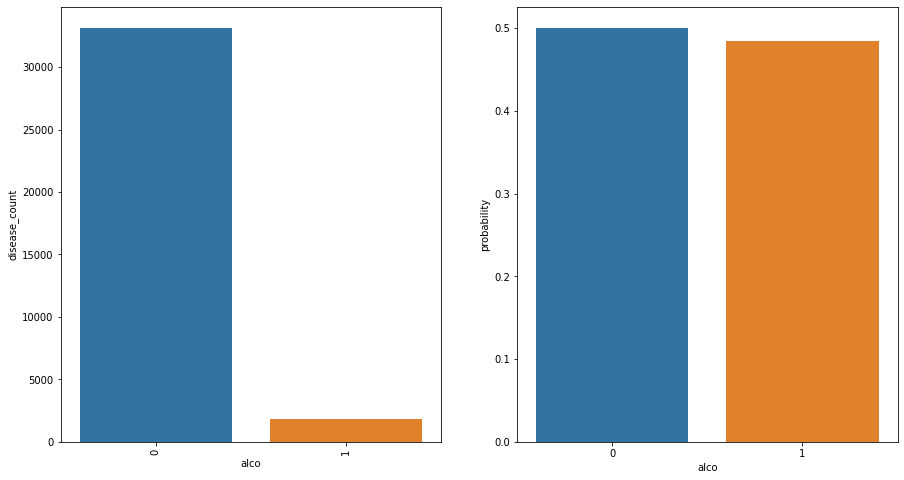

In [36]:
plt.figure(figsize=(15,8)) 

plt.subplot(1,2,1)
aux1 = df4[['alco', 'cardio']].groupby('alco').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='alco', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
aux2 = df4[['alco', 'cardio']].copy()
aux2 = aux2.groupby('alco').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='alco')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.barplot(x='alco', y='probability', data=aux1)

### 10) Pessoas não ativas são mais propensas a possuir doenças cardíacas.

**FALSO** Não há relação entre as duas variáveis quando avaliadas juntas sem o envolvimento de outras variáveis.

<AxesSubplot:xlabel='active', ylabel='probability'>

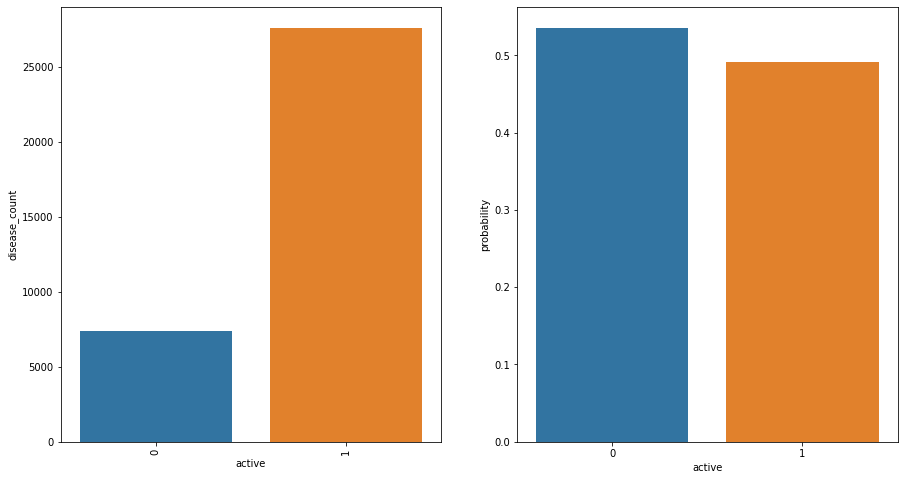

In [37]:
plt.figure(figsize=(15,8)) 

plt.subplot(1,2,1)
aux1 = df4[['active', 'cardio']].groupby('active').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='active', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
aux2 = df4[['active', 'cardio']].copy()
aux2 = aux2.groupby('active').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='active')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.barplot(x='active', y='probability', data=aux1)

### 11) Pessoas com pressão sistólica alta têm maior predisposição a desenvolver doenças cardíacas.

**VERDADEIRO** Pessoas com pressão sistólica alta têm maior predisposição a desenvolver doenças cardíacas.

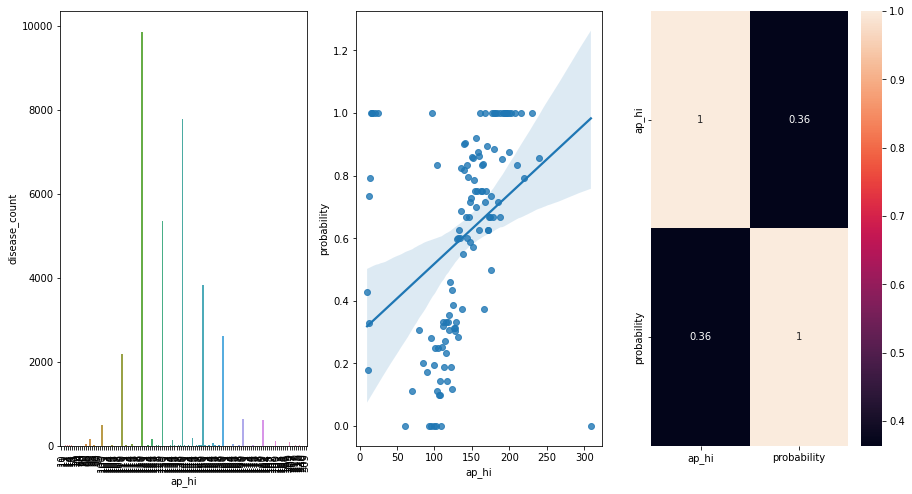

In [38]:
plt.figure(figsize=(15,8))

# Incosistência encontrada nos dados de ap_hi: trabalhando apenas com valores de ap_hi entre 10 e 400
aux = df4[(df4['ap_hi']>=10) & (df4['ap_hi']<=400)]

plt.subplot(1,3,1)
aux1 = aux[['ap_hi', 'cardio']].groupby('ap_hi').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='ap_hi', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = aux[['ap_hi', 'cardio']].copy()
aux2 = aux2.groupby('ap_hi').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='ap_hi')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='ap_hi', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['ap_hi', 'probability']].corr(method='pearson'), annot=True);

### 12) Pessoas com pressão diastólica alta têm maior predisposição a desenvolver doenças cardíacas.

**VERDADEIRO** Pessoas com pressão sistólica alta têm maior predisposição a desenvolver doenças cardíacas.

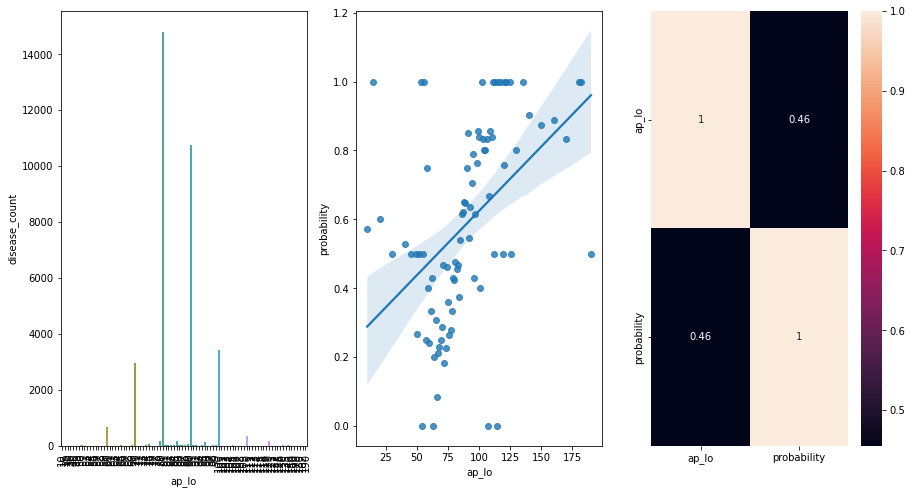

In [39]:
plt.figure(figsize=(15,8))

# Incosistência encontrada nos dados de ap_lo: trabalhando apenas com valores de ap_lo entre 10 e 400
aux = df4[(df4['ap_lo']>=10) & (df4['ap_lo']<=400)]

plt.subplot(1,3,1)
aux1 = aux[['ap_lo', 'cardio']].groupby('ap_lo').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='ap_lo', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = aux[['ap_lo', 'cardio']].copy()
aux2 = aux2.groupby('ap_lo').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='ap_lo')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='ap_lo', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['ap_lo', 'probability']].corr(method='pearson'), annot=True);

### 13) Pessoas com a relação pressões sistólica/diastólica alta têm maior predisposição a desenvolver doenças cardíacas.

**FALSA** Não há relação entre as duas variáveis quando avaliadas juntas sem o envolvimento de outras variáveis.

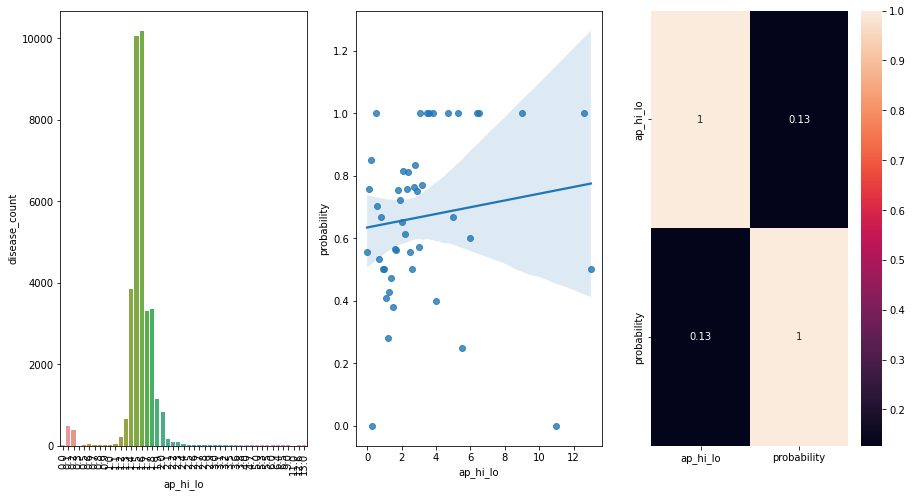

In [40]:
plt.figure(figsize=(15,8))

# Incosistência encontrada nos dados de ap_hi_lo: trabalhando apenas com valores de ap_hi_lo entre 0 e 13
aux = df4[(df4['ap_hi_lo']>=0) & (df4['ap_hi_lo']<=13)]

plt.subplot(1,3,1)
aux1 = aux[['ap_hi_lo', 'cardio']].groupby('ap_hi_lo').sum().reset_index()
aux1 = aux1.rename(columns={'cardio': 'disease_count'})
sns.barplot(x='ap_hi_lo', y='disease_count', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
aux2 = aux[['ap_hi_lo', 'cardio']].copy()
aux2 = aux2.groupby('ap_hi_lo').size().reset_index()
aux2 = aux2.rename(columns={0: 'total'})
aux1 = pd.merge(aux1, aux2, how='left', on='ap_hi_lo')

aux1['probability'] = aux1['disease_count']/aux1['total']
sns.regplot(x='ap_hi_lo', y='probability', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1[['ap_hi_lo', 'probability']].corr(method='pearson'), annot=True);

## 4.3  Análises multivariada

### 4.3.1 - Atributos numéricos

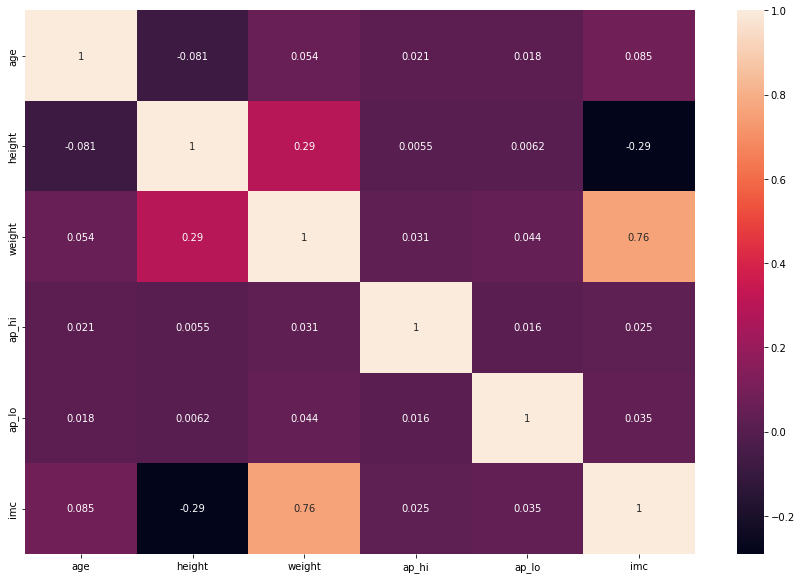

In [41]:
plt.figure(figsize=(15,10))
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

### 4.3.2 - Atributos categóricos

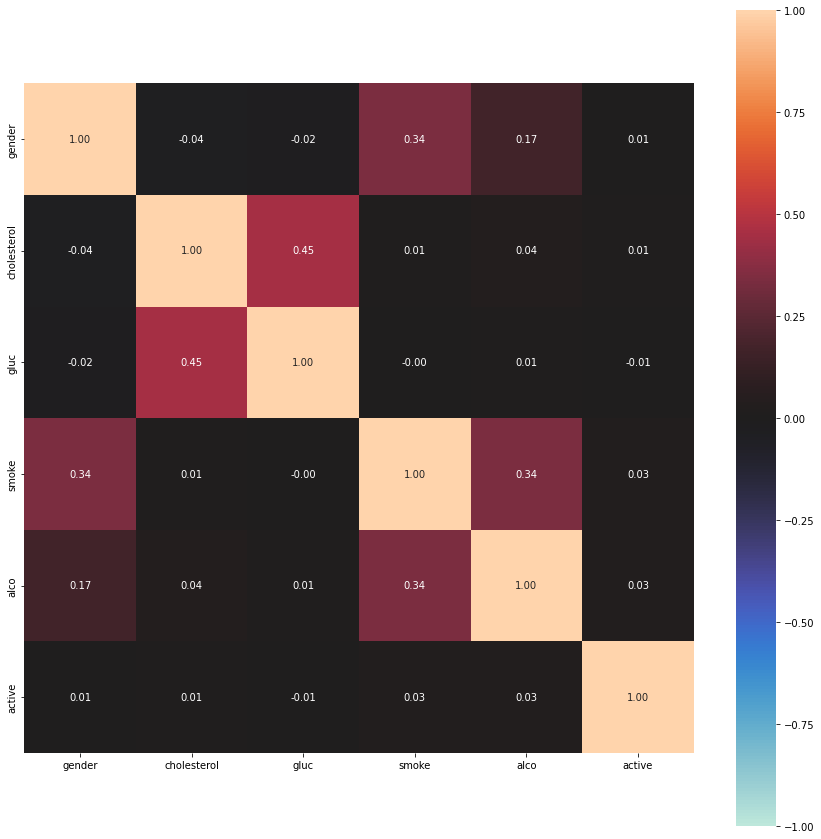

In [42]:
associations(cat_attributes, figsize=(15,15));

# 5 - PREPARAÇÃO DOS DADOS

In [43]:
df5 = df4.copy()

/tmp/ipykernel_4440/699681831.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df5.drop(['cardio', 'ap_hi_lo'], axis=1).hist(ax=ax, bins=50);


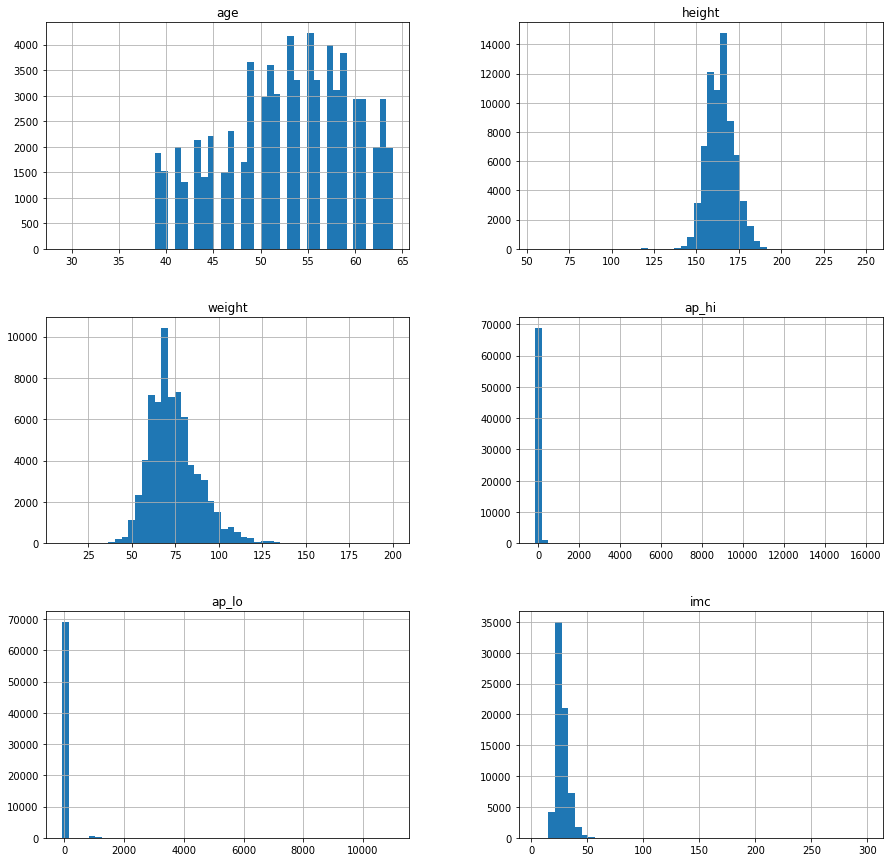

In [44]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df5.drop(['cardio', 'ap_hi_lo'], axis=1).hist(ax=ax, bins=50);

## 5.1 - Normalização

## 5.2 - Rescalling

In [45]:
mms = preprocessing.MinMaxScaler()
rs = preprocessing.RobustScaler()

In [46]:
# height
df5['height'] = rs.fit_transform(df5[['height']])

# weight
df5['weight'] = rs.fit_transform(df5[['weight']])

# ap_hi
df5['ap_hi'] = rs.fit_transform(df5[['ap_hi']])

# ap_lo
df5['ap_lo'] = rs.fit_transform(df5[['ap_lo']])

# imc
df5['imc'] = rs.fit_transform(df5[['imc']])

/tmp/ipykernel_4440/699681831.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df5.drop(['cardio', 'ap_hi_lo'], axis=1).hist(ax=ax, bins=50);


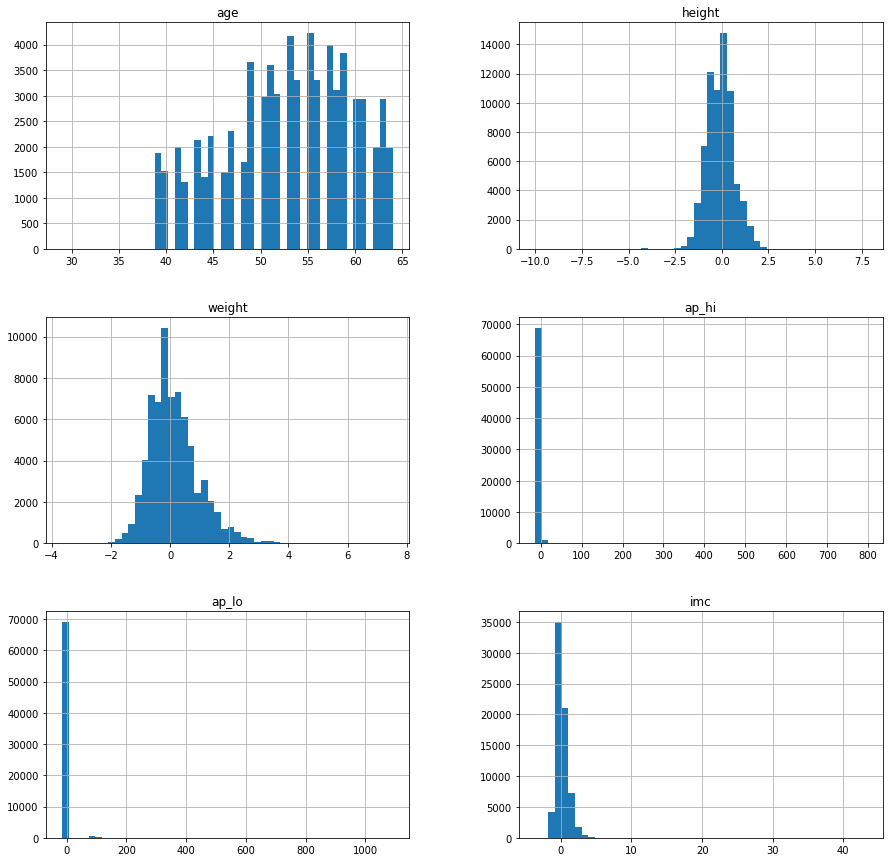

In [47]:
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
df5.drop(['cardio', 'ap_hi_lo'], axis=1).hist(ax=ax, bins=50);

## 5.3 - Enconding

O dataset original já havia tido suas variáveis categóricas encodadas, portanto estas features serão transformados em números inteiros

In [48]:
to_int64_dict = {'gender': 'int64', 
                  'cholesterol': 'int64', 
                  'gluc': 'int64', 
                  'smoke': 'int64', 
                  'alco': 'int64', 
                  'active': 'int64'}
df4 = df4.astype(to_int64_dict)

# 6 - FEATURE SELECTION

In [49]:
df6 = df5.copy()

In [50]:
X = df6.drop(['cardio', 'ap_hi_lo'], axis=1) # ap_hi_lo não é uma feature útil
y = df6['cardio'].copy()

In [51]:
# Split do dataset em training e test
x_train, x_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=32)

## 6.1 - Boruta como seletor de features

In [52]:
# define Modelo Seletor - ExtraTrees
etc = en.ExtraTreesClassifier(n_jobs=-1)

# define Boruta
boruta = BorutaPy(etc, n_estimators='auto', verbose=2, random_state=42).fit(x_train.values, y_train.values.ravel())

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	0
Rejected: 	7


In [53]:
cols_selected = boruta.support_.tolist()

# best features
cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()

# not selected by Boruta
cols_not_selected_boruta = list(np.setdiff1d(x_train.columns, cols_selected_boruta))

In [54]:
cols_selected_boruta

['age', 'weight', 'ap_hi', 'ap_lo', 'imc']

In [55]:
cols_not_selected_boruta

['active', 'alco', 'cholesterol', 'gender', 'gluc', 'height', 'smoke']

## 6.2 - Seleção manual das features

In [56]:
cols_selected_boruta = ['age', 'weight', 'ap_hi', 'ap_lo', 'imc']

# 7 - MACHINE LEARNING MODELLING

In [71]:
x_train = x_train[cols_selected_boruta]
x_test = x_test[cols_selected_boruta]

## 7.1 - Baseline model

In [72]:
cardio_list = df1['cardio'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
cardio_weights = df1['cardio'].value_counts(normalize=True).sort_index().tolist()

# Modelo
yhat_random = random.choices(population=cardio_list, k=k_num, weights=cardio_weights)

### 7.1.1 - Baseline model performance

Accuracy: 0.4937142857142857
Balanced Accuracy: 0.4937184682814338
Kappa Score: -0.012562563482862554
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      7039
           1       0.49      0.49      0.49      6961

    accuracy                           0.49     14000
   macro avg       0.49      0.49      0.49     14000
weighted avg       0.49      0.49      0.49     14000



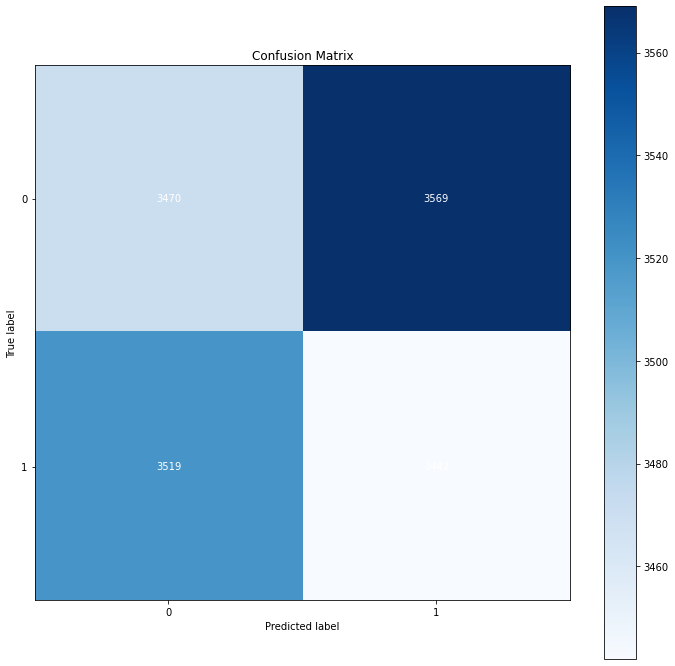

In [75]:
# Accuracy
acc_random = mts.accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = mts.balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Metrics
kappa_random = mts.cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification report
print(mts.classification_report(y_test, yhat_random))

# Confusion Matrix
mt.plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12));

## 7.2 - XGBoost Classifier

In [76]:
# model
model_xgb = XGBClassifier(booster='gbtree',
                          colsample_bytree=1,
                          max_depth=6, 
                          min_child_weight=1,
                          n_estimators=100, 
                          n_jobs=16,
                          random_state=0, 
                          subsample=1)

# training
model_xgb.fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# prediction prepare
y_test_xgb = y_test.to_numpy()
yhat_xgb = yhat_xgb.reshape(1, -1)[0]

Accuracy: 0.7242142857142857
Balanced Accuracy: 0.7240063410947919
Kappa Score: 0.4481914063472995
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      7039
           1       0.74      0.69      0.71      6961

    accuracy                           0.72     14000
   macro avg       0.73      0.72      0.72     14000
weighted avg       0.73      0.72      0.72     14000



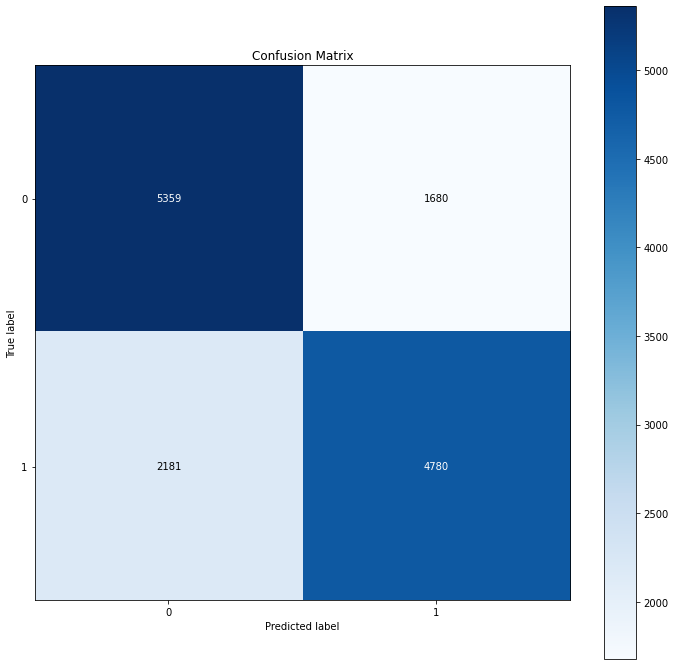

In [78]:
# Accuracy
acc_xgb = mts.accuracy_score(y_test_xgb, yhat_xgb)
print('Accuracy: {}'.format(acc_xgb))

# Balanced Accuracy
balanced_acc_xgb = mts.balanced_accuracy_score(y_test_xgb, yhat_xgb)
print('Balanced Accuracy: {}'.format(balanced_acc_xgb))

# Kappa Metrics
kappa_xgb = mts.cohen_kappa_score(y_test_xgb, yhat_xgb)
print('Kappa Score: {}'.format(kappa_xgb))

# Classification report
print(mts.classification_report(y_test_xgb, yhat_xgb))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_xgb, yhat_xgb, normalize=False, figsize=(12, 12));

### 7.2.1 - XGBClassifier Performance - Cross-Validation

In [80]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # model definition
    model_xgb = XGBClassifier(booster='gbtree',
                              colsample_bytree=1,
                              max_depth=6, 
                              min_child_weight=1,
                              n_estimators=100, 
                              n_jobs=16,
                              random_state=0, 
                              subsample=1)
    

    # training model
    model_xgb.fit(x_train_fold, y_train_fold)
    
    # prediction
    yhat_xgb = model_xgb.predict(x_val_fold)
    
    # prepare data
    y_test_xgb = y_val_fold.to_numpy()
    yhat_xgb = yhat_xgb.reshape(1, -1)[0]
    
    # metrics
    ## Balanced Accuracy 
    balanced_acc_xgb = mts.balanced_accuracy_score(y_test_xgb, yhat_xgb)
    balanced_acc_list.append(balanced_acc_xgb)
    
    ## Kappa Metrics
    kappa_acc_xgb = mts.cohen_kappa_score(y_test_xgb, yhat_xgb)
    kappa_acc_list.append(kappa_acc_xgb)
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [81]:
print(' Avg Balanced accuracy: {} +/- {}'.format(np.mean(balanced_acc_list), np.std(balanced_acc_list)))
print(' Kappa Balanced accuracy: {} +/- {}'.format(np.mean(kappa_acc_list), np.std(kappa_acc_list)))

 Avg Balanced accuracy: 0.7199907049596176 +/- 0.002466991138499668
 Kappa Balanced accuracy: 0.439958040434872 +/- 0.004931987296637495


## 7.3 - Random Forest Classifier

In [82]:
# model
model_rfc = RandomForestClassifier()

# training
model_rfc.fit(x_train, y_train)

#predict
yhat_rfc = model_rfc.predict(x_test)

# prediction prepare
y_test_rfc = y_test.to_numpy()
yhat_rfc = yhat_rfc.reshape(1, -1)[0]

Accuracy: 0.6856428571428571
Balanced Accuracy: 0.6856478238844924
Kappa Score: 0.37128471347362557
              precision    recall  f1-score   support

           0       0.69      0.68      0.69      7039
           1       0.68      0.69      0.68      6961

    accuracy                           0.69     14000
   macro avg       0.69      0.69      0.69     14000
weighted avg       0.69      0.69      0.69     14000



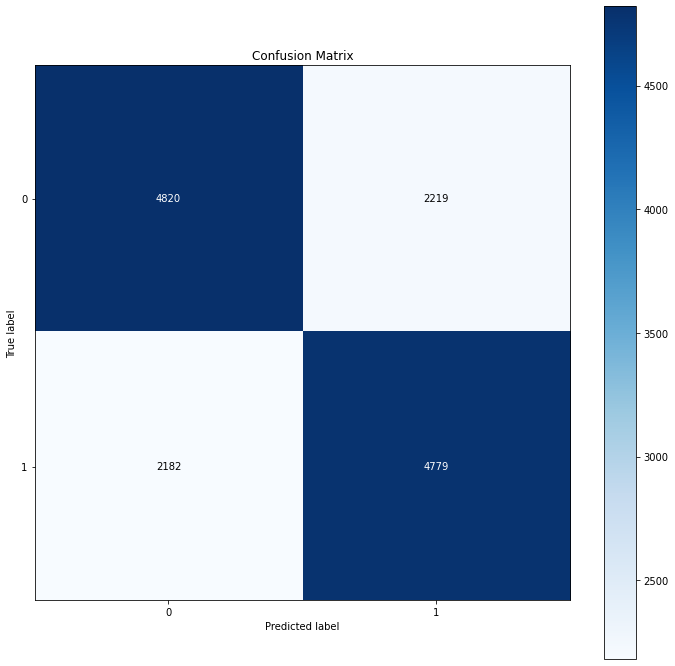

In [83]:
# Accuracy
acc_rfc = mts.accuracy_score(y_test, yhat_rfc)
print('Accuracy: {}'.format(acc_rfc))

# Balanced Accuracy
balanced_acc_rfc = mts.balanced_accuracy_score(y_test_rfc, yhat_rfc)
print('Balanced Accuracy: {}'.format(balanced_acc_rfc))

# Kappa Metrics
kappa_rfc = mts.cohen_kappa_score(y_test_rfc, yhat_rfc)
print('Kappa Score: {}'.format(kappa_rfc))

# Classification report
print(mts.classification_report(y_test_rfc, yhat_rfc))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_rfc, yhat_rfc, normalize=False, figsize=(12, 12));

### 7.3.1 - RandomForestClassifier Performance - Cross-Validation

In [84]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=32)

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split(x_train, y_train):
    print('Fold Number: {}/{}'.format(i, num_folds))
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # model definition
    model_rfc = RandomForestClassifier()
    

    # training model
    model_rfc.fit(x_train_fold, y_train_fold)
    
    # prediction
    yhat_rfc = model_rfc.predict(x_val_fold)
        
    # prepare data
    y_test_rfc = y_val_fold.to_numpy()
    yhat_rfc = yhat_rfc.reshape(1, -1)[0]
    
    # metrics
    ## Balanced Accuracy 
    balanced_acc_rfc = mts.balanced_accuracy_score(y_test_rfc, yhat_rfc)
    balanced_acc_list.append(balanced_acc_rfc)
    
    ## Kappa Metrics
    kappa_acc_rfc = mts.cohen_kappa_score(y_test_rfc, yhat_rfc)
    kappa_acc_list.append(kappa_acc_rfc)
    
    i += 1

Fold Number: 1/5
Fold Number: 2/5
Fold Number: 3/5
Fold Number: 4/5
Fold Number: 5/5


In [85]:
print(' Avg Balanced accuracy: {} +/- {}'.format(np.mean(balanced_acc_list), np.std(balanced_acc_list)))
print(' Kappa Balanced accuracy: {} +/- {}'.format(np.mean(kappa_acc_list), np.std(kappa_acc_list)))

 Avg Balanced accuracy: 0.6847544371072873 +/- 0.0029312206664921896
 Kappa Balanced accuracy: 0.36950549012910233 +/- 0.005861961103743238


## 7.4 - Neural Network - MLP

In [86]:
ohe = preprocessing.OneHotEncoder()
y_train_nn = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()

In [87]:
print('Number of rows: {}'.format(x_train.shape[0]))
print('Number of features: {}'.format(x_train.shape[1]))
print('Number of classes: {}'.format(y_train.nunique()))

Number of rows: 56000
Number of features: 5
Number of classes: 2


In [88]:
# model definition
model = ml.Sequential()
model.add(l.Dense(8, input_dim=x_train.shape[1], activation='relu'))
model.add(l.Dense(2, activation='softmax'))

# model_compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# trin model
model.fit(x_train, y_train_nn, epochs=50)

2022-06-08 22:38:53.289927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 22:38:53.289973: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 22:38:53.290001: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fausto-Inspiron-7520): /proc/driver/nvidia/version does not exist


Epoch 1/50
1750/1750 [==============================] - 4s 2ms/step - loss: 0.7688 - accuracy: 0.6881
Epoch 2/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.6005 - accuracy: 0.7106
Epoch 3/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5881 - accuracy: 0.7103
Epoch 4/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5858 - accuracy: 0.7117
Epoch 5/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5845 - accuracy: 0.7109
Epoch 6/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5838 - accuracy: 0.7101
Epoch 7/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5817 - accuracy: 0.7126
Epoch 8/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5825 - accuracy: 0.7125
Epoch 9/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.5818 - accuracy: 0.7124
Epoch 10/50
1750/1750 [==============================] - 3s 2ms/step - loss: 0.582

In [89]:
# prediction
pred_nn = model.predict(x_test)

# invert_prediction
yhat_nn = ohe.inverse_transform(pred_nn)

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape(1, -1)[0]

438/438 [==============================] - 1s 1ms/step


Accuracy: 0.7197857142857143
Balanced Accuracy: 0.7195115689203332
Kappa Score: 0.4392563364074825
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      7039
           1       0.74      0.67      0.70      6961

    accuracy                           0.72     14000
   macro avg       0.72      0.72      0.72     14000
weighted avg       0.72      0.72      0.72     14000



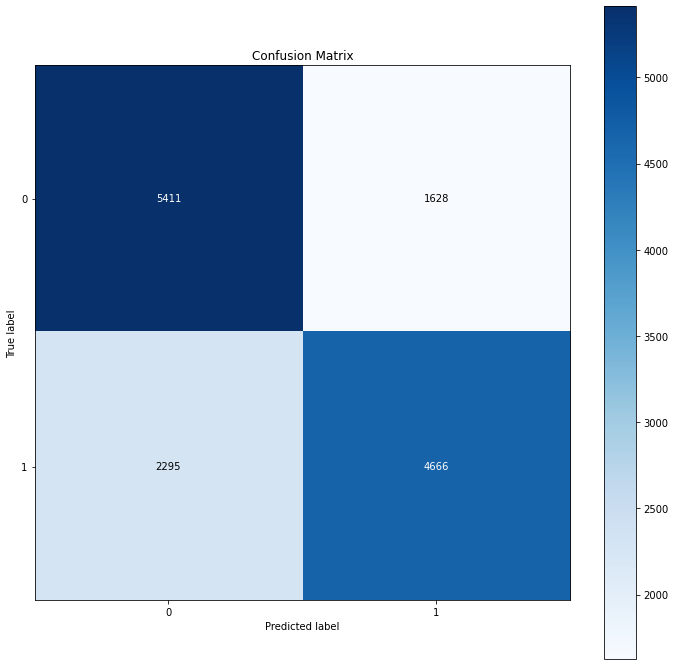

In [90]:
# Accuracy
acc_nn = mts.accuracy_score(y_test, yhat_nn)
print('Accuracy: {}'.format(acc_nn))

# Balanced Accuracy
balanced_acc_nn = mts.balanced_accuracy_score(y_test_nn, yhat_nn)
print('Balanced Accuracy: {}'.format(balanced_acc_nn))

# Kappa Metrics
kappa_nn = mts.cohen_kappa_score(y_test_nn, yhat_nn)
print('Kappa Score: {}'.format(kappa_nn))

# Classification report
print(mts.classification_report(y_test_nn, yhat_nn))

# Confusion Matrix
mt.plot_confusion_matrix(y_test_nn, yhat_nn, normalize=False, figsize=(12, 12));

### 7.4.1 - Neural Network - Cross-Validation

In [92]:
# generate k-fold
num_folds = 5
kfold = ms.StratifiedKFold( n_splits=num_folds, shuffle=True, random_state=32 )

balanced_acc_list = []
kappa_acc_list = []

i = 1
for train_ix, val_ix in kfold.split( x_train, y_train ):
    print( 'Fold Number: {}/{}'.format( i, num_folds ) )
    
    # get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]
    
    # target hot-encoding
    ohe = preprocessing.OneHotEncoder()
    y_train_fold_nn = ohe.fit_transform( y_train_fold.values.reshape( -1, 1 ) ).toarray()

    # model definition
    model = ml.Sequential()
    model.add( l.Dense( 8, input_dim=x_train.shape[1], activation='relu' ) )
    model.add( l.Dense( 2, activation='softmax') )

    # compile model
    model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

    # training model
    model.fit( x_train_fold, y_train_fold_nn, epochs=100, batch_size=32, verbose=0 )

    # prediction
    pred_nn = model.predict( x_val_fold )
    yhat_nn = ohe.inverse_transform( pred_nn )
    
    # prepare data
    y_test_nn = y_val_fold.to_numpy()
    yhat_nn = yhat_nn.reshape( 1, -1 )[0]

    # metrics
    ## Balanced Accuracy 
    balanced_acc_nn = mts.balanced_accuracy_score( y_test_nn, yhat_nn )
    balanced_acc_list.append( balanced_acc_nn )
    
    ## Kappa Metrics
    kappa_acc_nn = mts.cohen_kappa_score( y_test_nn, yhat_nn )
    kappa_acc_list.append( kappa_acc_nn )
    
    i += 1

Fold Number: 1/5
350/350 [==============================] - 1s 1ms/step
Fold Number: 2/5
350/350 [==============================] - 0s 1ms/step
Fold Number: 3/5
350/350 [==============================] - 0s 1ms/step
Fold Number: 4/5
350/350 [==============================] - 1s 1ms/step
Fold Number: 5/5
350/350 [==============================] - 1s 1ms/step


In [93]:
print(' Avg Balanced accuracy: {} +/- {}'.format(np.mean(balanced_acc_list), np.std(balanced_acc_list)))
print(' Kappa Balanced accuracy: {} +/- {}'.format(np.mean(kappa_acc_list), np.std(kappa_acc_list)))

 Avg Balanced accuracy: 0.7180766479954144 +/- 0.0012846886476340004
 Kappa Balanced accuracy: 0.4361174594404084 +/- 0.0025641733758326813
